## Import library

In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import MultipleLocator
from sklearn.cluster import DBSCAN
import pymc3 as pm
import arviz as az
import hyperspy.api as hs
from concurrent.futures.process import ProcessPoolExecutor
from dask.distributed import Client
from dask import delayed
from itertools import repeat
from tqdm import tqdm

from mylib.user_func import (
    detect_peaks,
    centroid,
    gauss,
    bayesian_inference,
    generate_cmap,
    analysis_pervskite,
)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Load image and set parameters

In [130]:
# Parameters
model = "Gaussian"  # "CoM" or "Gaussian"
size_peak_search = 20  # pix size of ROI for peak search
size_peak = 20  # pix size of ROI for Gaussian (or CoM) fitting
threshold = 0.01  # Minimum threshold of peak intensity against maximum intensity of image
edge = 1.0  # region (edge * size_peak) where peak is ignored
n_iter = 6  # Number of loops for Gaussian fit
eps = 3  # DBSCAN parameter
ratio = 10  # Magnification of arrows in displacement map
calibration = 10  # pm/pix(spectra_2K)
display_sigma = 1  # Graph display error size (1: 68%, 2: 95%, 3: 99.7%)
scan_distortion = 0  # Scan influence on displacement determination accuracy error (1 standard deviation) [pm]
input_file = "SrTiO3_surphase.dm4"
output_dir = "SrTiO3_50cell_simu_intensity100"
FWHM = size_peak / 2  # Initial value of FWHM for Gaussian fitting

# Get file path
cur_dir = os.getcwd()  # Get filepath of current directory
data_dir = os.path.join(os.path.dirname(cur_dir), "data")
if os.name == "nt":  # If os is Windows
    ds = hs.load(os.path.join(data_dir, input_file))
elif os.name == "posix":  # If os is Linux or Mac
    ds = hs.load(os.path.join(data_dir, input_file))

# Import image
s = hs.signals.Signal1D(ds)
ydim, xdim = s.data.shape
img = np.flipud(s.data)  # Flip vertically because dm4 has inverse definition of y-axis against matplotlib

## Detect peaks roughly

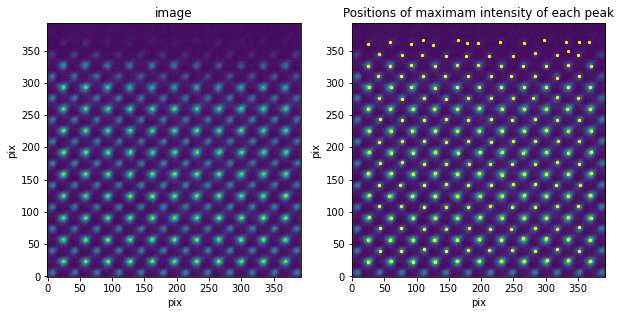

In [36]:
# Search peaks roughly
peaks_maximam = list(detect_peaks(img, edge, filter_size=size_peak_search, order=threshold))

# Make plots
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(img, origin="lower")
ax1.set_title("image")
ax1.set_xlabel("pix")
ax1.set_ylabel("pix")

ax2.imshow(img, origin="lower")
ax2.scatter(peaks_maximam[1], peaks_maximam[0], s=5, c="yellow", marker="o")
ax2.set_title("Positions of maximam intensity of each peak")
ax2.set_xlabel("pix")
ax2.set_ylabel("pix")

plt.show()

In [ ]:
# Make plots
outliers = []
outliers = [222, 214, 210, 221]

peaks_maximam[1] = np.delete(peaks_maximam[1], outliers)
peaks_maximam[0] = np.delete(peaks_maximam[0], outliers)

fig = plt.figure(figsize=(40,20))
ax = fig.add_subplot(111)
ax.imshow(img, origin="lower")
ax.scatter(peaks_maximam[1], peaks_maximam[0], s=10, c="yellow", marker="o")
for i in range(len(peaks_maximam[1])):
    ax.text(peaks_maximam[1][i], peaks_maximam[0][i], str(i), color="black", fontsize=12)
ax.set_title("Positions of maximam intensity of each peak")
ax.set_xlabel("pix")
ax.set_ylabel("pix")
ax.set_xlim(0, xdim)
ax.set_ylim(0, ydim)
plt.show()

## Clustering Peaks

In [39]:
# Peak detection
min_samples = int((xdim / size_peak) / 2 * 0.6)  # Lower threshold on cluster formation factors in DBSCAN clustering

# Clustering by DBSCAN
peaks_x = peaks_maximam[1]
peaks_y = peaks_maximam[0]
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples).fit(np.reshape(peaks_y, [-1, 1]))
labels = dbscan_model.labels_ + 1
unique_labels = np.unique(labels)

col = np.sum(unique_labels != 0)  # Count labels that are not noise (0)
inlier_peaks_x = peaks_x[~(labels == 0)]
inlier_peaks_y = peaks_y[~(labels == 0)]
cluster_centers = np.array([np.average(peaks_y[labels == i]) for i in unique_labels if i != 0])  # Exclude the noise label (0)
labels = labels[~(labels == 0)] - 1

print("Number of peaks = {0}".format(len(peaks_maximam[0])))
print("Number of rows = {0}".format(col))
print("Number of atoms in rows = {0}".format(int(len(labels) / col)))
print("Minimun limit in rows = {0}".format(min_samples * 2))

Number of peaks = 221
Number of rows = 21
Number of atoms in rows = 10
Minimun limit in rows = 10


## Peak fit using simple 2D Gaussian

In [40]:
# Fit 2D gaussian
#fit_method = "simple"
decimals = [0, 1, 4]  # Determine the number of decimal places to consider when determining duplicate atomic positions (pix)

# Calculate atomic positions
for decimal in decimals:
    peaks = []
    gausses = []
    print("decimal = {0}".format(decimal))
    for h in tqdm(range(len(peaks_x))):
        px = peaks_x[h]
        py = peaks_y[h]
        for i in range(n_iter):
            if model == "CoM":
                cx,cy = centroid(img[int(round(py-size_peak/2)):int(round(py+size_peak/2)), 
                                     int(round(px-size_peak/2)):int(round(px+size_peak/2))])
            if model == "Gaussian":
                cx,cy = gauss(img[int(round(py-size_peak/2)):int(round(py+size_peak/2)), 
                                  int(round(px-size_peak/2)):int(round(px+size_peak/2))], size_peak, FWHM)
            px = round(round(px-size_peak/2)+cx, decimal)
            py = round(round(py-size_peak/2)+cy, decimal)
        if (px, py) not in peaks:
            peaks.append((px, py))
        if (cx, cy) not in gausses:
            gausses.append((cx, cy))
    print("Number of peaks = {0} ⇒ {1}\n".format(len(peaks_x), len(peaks)))
    peaks_x = [ x for x, y in peaks ]
    peaks_y = [ y for x, y in peaks ]
    gausses_x = [ x for x, y in gausses ]
    gausses_y = [ y for x, y in gausses ]

decimal = 0


100%|██████████| 221/221 [00:03<00:00, 68.67it/s]


Number of peaks = 221 ⇒ 221

decimal = 1


100%|██████████| 221/221 [00:03<00:00, 70.06it/s]


Number of peaks = 221 ⇒ 221

decimal = 4


100%|██████████| 221/221 [00:03<00:00, 67.97it/s]

Number of peaks = 221 ⇒ 221



## Check for double count

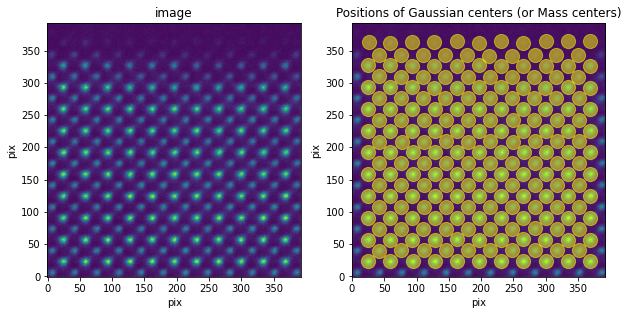

In [43]:
# Make plots
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(img, origin="lower")
ax1.set_title("image")
ax1.set_xlabel("pix")
ax1.set_ylabel("pix")

ax2.imshow(img, origin="lower")
ax2.scatter(peaks_x, peaks_y, s=200, c="yellow", marker="o", alpha=0.5)    #sの値を適宜調整して、見やすくすると良い
#for i in range(len(peaks_x)):
    #ax2.text(peaks_x[i], peaks_y[i], str(i), color="black", fontsize=12)
ax2.set_title("Positions of Gaussian centers (or Mass centers)")
ax2.set_xlabel("pix")
ax2.set_ylabel("pix")

plt.show()

## Peak fit using 2D Gaussian with Bayesian inference

In [44]:
workers = 2  # workers < num_CPU_core/3
num_sample = 2000  # number of samples for Bayesian inference
chains = 2

# Parallel processing of bayesian inference
patch = [img[int(round(peaks_y[i] - size_peak / 2)):int(round(peaks_y[i] + size_peak / 2)),
             int(round(peaks_x[i] - size_peak / 2)):int(round(peaks_x[i] + size_peak / 2))]
         for i in range(len(peaks))]
summary_all = [None] * len(patch)

# Prepare arguments for bayesian_inference function
args = zip(repeat(size_peak), patch, repeat(num_sample), repeat(chains))

# Execute bayesian_inference function in parallel
with ProcessPoolExecutor(max_workers=workers) as executor:
    futures = [executor.submit(bayesian_inference, *arg) for arg in args]

    # Set up progress bar
    progress_bar = tqdm(total=len(futures), desc="Processing")

    # Process the futures in the order they were submitted
    for i, future in enumerate(futures):
        # Wait for the future to complete
        result = future.result()
        # Update the progress bar
        progress_bar.update(1)
        # Store the result in summary_all
        summary_all[i] = result

    # Close the progress bar
    progress_bar.close()


Processing: 100%|██████████| 221/221 [4:36:43<00:00, 75.13s/it]  


## Peak fit using 2D Gaussian with Bayesian inference (Dask)

In [ ]:
workers = 6  # workers < num_CPU_core/3
num_sample = 2000  # number of samples for Bayesian inference
chains = 1

# Parallel processing of bayesian inference
patch = [img[int(round(peaks_y[i] - size_peak / 2)):int(round(peaks_y[i] + size_peak / 2)),
             int(round(peaks_x[i] - size_peak / 2)):int(round(peaks_x[i] + size_peak / 2))]
         for i in range(len(peaks))]
summary_all = [None] * len(patch)

# Prepare arguments for bayesian_inference function
args = zip(repeat(size_peak), patch, repeat(num_sample), repeat(chains))

# Execute bayesian_inference function in parallel
futures = [delayed(bayesian_inference)(*arg) for arg in args]

# Compute the results in parallel
client = Client(processes=True, n_workers=workers, threads_per_worker=1)
results = client.compute(futures)

# Set up progress bar
progress_bar = tqdm(total=len(futures), desc="Processing")

# Process the results in the order they were submitted
for i, future in enumerate(results):
    # Wait for the result to complete
    summary = future.result()
    # Update the progress bar
    progress_bar.update(1)
    # Store the result in summary_all
    summary_all[i] = summary

# Close the progress bar
progress_bar.close()

In [45]:
# Confirmation of main results of bayesian inference
pd.options.display.precision = 3
summary_df = pd.DataFrame([], index=[i for i in range(len(peaks))], columns=["Mean-x [pix]", "Mean-y [pix]", "SD-x [pix]", "SD-y [pix]", "r_hat"])
for i in range(len(peaks)):
    summary_df.loc[i, "Mean-x [pix]"] = summary_all[i][0].loc["Atom Position (μ)[0]", "mean"]
    summary_df.loc[i, "Mean-y [pix]"] = summary_all[i][0].loc["Atom Position (μ)[1]", "mean"]
    summary_df.loc[i, "SD-x [pix]"] = summary_all[i][0].loc["Atom Position (μ)[0]", "sd"]
    summary_df.loc[i, "SD-y [pix]"] = summary_all[i][0].loc["Atom Position (μ)[1]", "sd"]
    summary_df.loc[i, "r_hat"] = summary_all[i][0].loc["Atom Position (μ)[0]", "r_hat"]
pd.set_option("display.max_rows", len(summary_df))

summary_df

,Mean-x [pix],Mean-y [pix],SD-x [pix],SD-y [pix],r_hat
0,10.138,10.475,0.047,0.041,1.0
1,9.748,10.283,0.046,0.043,1.0
2,10.017,10.4,0.046,0.041,1.0
3,10.347,10.265,0.039,0.037,1.0
4,10.389,9.605,0.042,0.04,1.0
5,9.831,10.48,0.037,0.039,1.01
6,10.015,9.547,0.044,0.039,1.0
7,10.386,9.554,0.041,0.038,1.0
8,9.563,10.334,0.042,0.039,1.0
9,9.965,9.557,0.045,0.04,1.0


In [46]:
# Calculate most likely atomic positions
peaks_x_bayes = np.zeros_like(peaks_x)
peaks_y_bayes = np.zeros_like(peaks_y)

for i in range(len(peaks)):
    peaks_x_bayes[i] = round(round(peaks_x[i] - size_peak / 2) + summary_all[i][0].loc["Atom Position (μ)[0]", "mean"], decimal)
    peaks_y_bayes[i] = round(round(peaks_y[i] - size_peak / 2) + summary_all[i][0].loc["Atom Position (μ)[1]", "mean"], decimal)

In [47]:
# Calcurate possible peak positions (n=num_sample) from posterior distributiuon of Bayesian inference
pred_sampled_peaks_x = [[] for _ in range(num_sample)]
pred_sampled_peaks_y = [[] for _ in range(num_sample)]

for i in range(len(peaks)):
    for k in summary_all[i][1].values():
        for j in range(num_sample):
            pred_sampled_peaks_x[j].append(round(round(peaks_x[i] - size_peak / 2) + k[j][0], decimal))
            pred_sampled_peaks_y[j].append(round(round(peaks_y[i] - size_peak / 2) + k[j][1], decimal))

## Analysis for Pervskite crystal

In [48]:
# Calculate Ti displacement for conventional method
distances, flat_distance_x, flat_distance_y, flat_align_peaks_x, flat_align_peaks_y, flat_center_x, flat_center_y = analysis_pervskite(img, col, peaks_x, peaks_y, size_peak)

# Calculate most likely Ti displacement for Bayesian inference
distances_bayes, flat_distance_x_bayes, flat_distance_y_bayes, flat_align_peaks_x_bayes, flat_align_peaks_y_bayes, flat_center_x_bayes, flat_center_y_bayes = analysis_pervskite(img, col, peaks_x_bayes, peaks_y_bayes, size_peak)

# Calcurate possible Ti displacement from posterior distribution of Bayesian inference
pred_distances = [[] for _ in range(num_sample)]
pred_flat_distance_x = [[] for _ in range(num_sample)]
pred_flat_distance_y = [[] for _ in range(num_sample)]
pred_flat_align_peaks_x = [[] for _ in range(num_sample)]
pred_flat_align_peaks_y = [[] for _ in range(num_sample)]
pred_flat_center_x = [[] for _ in range(num_sample)]
pred_flat_center_y = [[] for _ in range(num_sample)]

for i in tqdm(range(num_sample)):
    pred_distances[i], pred_flat_distance_x[i], pred_flat_distance_y[i], pred_flat_align_peaks_x[i], pred_flat_align_peaks_y[i], pred_flat_center_x[i], pred_flat_center_y[i] = analysis_pervskite(img, col, pred_sampled_peaks_x[i], pred_sampled_peaks_y[i], size_peak)

100%|██████████| 2000/2000 [11:09<00:00,  2.99it/s]


## Make Plots of Ti displacements for conventional method

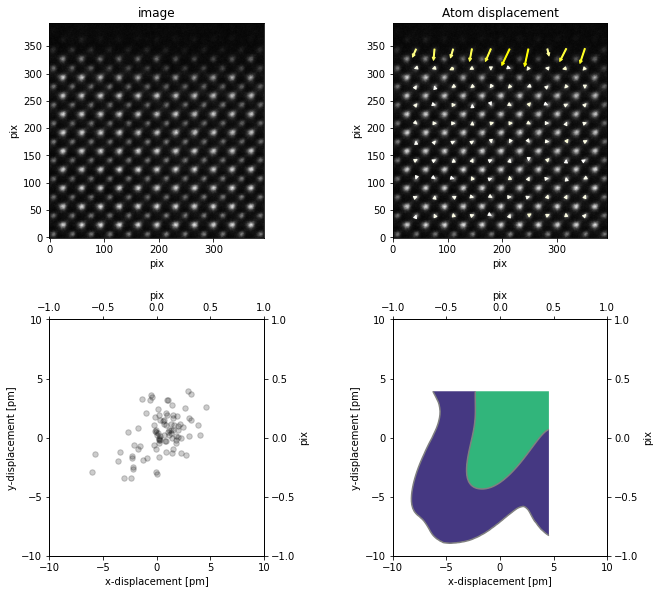

Mean of displacement [pm] = (-0.29, -1.91)
Standard deviation(x, y) of displacement [pm] = (3.20, 7.24)
Standard deviation(kobayashi) of displacement [pm] = (6.84)


In [53]:
# pred_flat_distanceをcalibration倍したリストを作成
multi_flat_distance_x = [ x * calibration for x in flat_distance_x ]
multi_flat_distance_y = [ y * calibration for y in flat_distance_y ]

# Define colors of arrows
cm = generate_cmap(['white', 'yellow'])
color = np.array([ distances[i] / sorted(distances)[-1] for i in range(len(flat_distance_x))])
color = np.where(color>=1, 0.99, color)
color = cm(color)

# Create a GridSpec layout
gs = gridspec.GridSpec(2, 2, 
                      width_ratios=[1, 1], 
                      height_ratios=[1, 1], 
                      wspace=0.6, 
                      hspace=0.3
                      )

# Make plots
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])

ax1.imshow(img, origin="lower", cmap="gray")
ax1.set_title("image")
ax1.set_xlabel("pix")
ax1.set_ylabel("pix")

ax2.imshow(img, origin="lower", cmap="gray")
ax2.set_title("Atom displacement")
for i in range(len(flat_distance_x)):
    ax2.annotate('', 
                xy=[ flat_center_x[i] + flat_distance_x[i] * ratio, flat_center_y[i] + flat_distance_y[i] * ratio ], 
                xytext=[flat_center_x[i], flat_center_y[i]], 
                arrowprops=dict(shrink=0, width=1, headwidth=3, headlength=3, connectionstyle='arc3', facecolor=color[i], edgecolor=color[i])
                )    #"xy"が終点、"xytext"が始点
ax2.set_xlabel("pix")
ax2.set_ylabel("pix")

ax3.scatter(np.array(flat_distance_x) * calibration, 
           np.array(flat_distance_y) * calibration, 
           s=30, 
           c="black", 
           marker="o", 
           alpha=0.2
           )
ax3.set_xlabel("x-displacement [pm]")
ax3.set_ylabel("y-displacement [pm]")
#ax3.set_xlim(-sorted(distances)[-1], sorted(distances)[-1])
#ax3.set_ylim(-sorted(distances)[-1], sorted(distances)[-1])
ax3.set_xlim(-10, 10)
ax3.set_ylim(-10, 10)
ax3_twinx = ax3.twinx()  # Create a new y-axis
ax3_twiny = ax3.twiny()  # Create a new x-axis
ax3_twinx.set_ylabel("pix")  # Set the label for the new y-axis
ax3_twiny.set_xlabel("pix")  # Set the label for the new x-axis
ax3_twiny.set_xlim(-1, 1)
ax3_twinx.set_ylim(-1, 1)

az.plot_kde(multi_flat_distance_x, 
           values2=multi_flat_distance_y, 
           ax=ax4, 
           hdi_probs=[ 0.6827, 0.9545 ]
           )
ax4.set_xlabel("x-displacement [pm]")
ax4.set_ylabel("y-displacement [pm]")
ax4.set_xlim(-10, 10)
ax4.set_ylim(-10, 10)
ax4_twinx = ax4.twinx()  # Create a new y-axis
ax4_twiny = ax4.twiny()  # Create a new x-axis
ax4_twinx.set_ylabel("pix")  # Set the label for the new y-axis
ax4_twiny.set_xlabel("pix")  # Set the label for the new x-axis
ax4_twinx.set_ylim(-1, 1)
ax4_twiny.set_xlim(-1, 1)

# Set integer tick intervals for ax4 and ax5
for ax in [ax3, ax4]:
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(5))
ax3_twinx.yaxis.set_major_locator(MultipleLocator(0.5))
ax3_twiny.xaxis.set_major_locator(MultipleLocator(0.5))
ax4_twinx.yaxis.set_major_locator(MultipleLocator(0.5))
ax4_twiny.xaxis.set_major_locator(MultipleLocator(0.5))

plt.savefig(data_dir + "\\" + "summary_conventional.png", dpi=1200)
plt.show()

#変位の平均と標準偏差の表示
std_x = np.std(np.array(flat_distance_x)) * calibration
std_y = np.std(np.array(flat_distance_y)) * calibration
flat_distance = np.sqrt(np.array(flat_distance_x) ** 2 + np.array(flat_distance_y) ** 2)*calibration
kobayashi_std = np.std(flat_distance)

print("Mean of displacement [pm] = ({0:.2f}, {1:.2f})".format(np.mean(np.array(flat_distance_x)) * calibration, np.mean(np.array(flat_distance_y)) * calibration))
print("Standard deviation(x, y) of displacement [pm] = ({0:.2f}, {1:.2f})".format(std_x, std_y))
print("Standard deviation(kobayashi) of displacement [pm] = ({0:.2f})".format(kobayashi_std))
#print("Standard deviation of displacement [pm] = ({0:.2f}, {1:.2f})".format(np.std(np.array(distances))*calibration))

## Make plots of Ti displacement for Bayesian inference

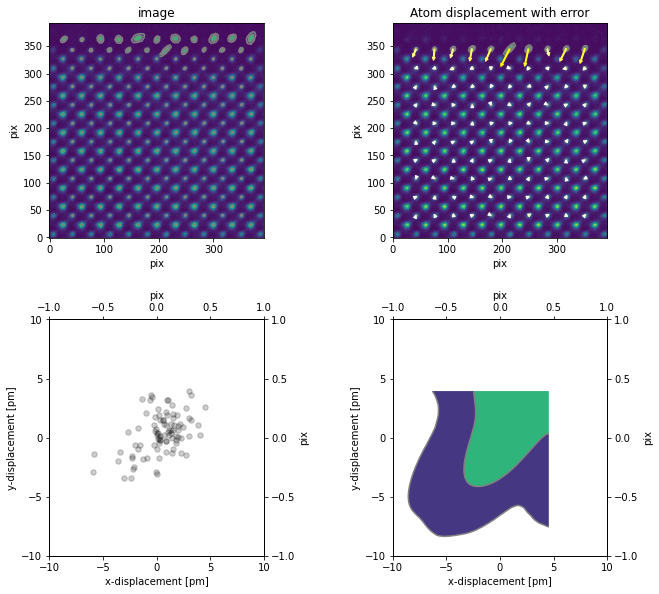

In [132]:
# pred_flat_distanceをcalibration倍したリストを作成
multi_flat_distance_x_bayes = [ x * calibration for x in flat_distance_x_bayes ]
multi_flat_distance_y_bayes = [ y * calibration for y in flat_distance_y_bayes ]

# Define colors of arrows
cm = generate_cmap(['white', 'yellow'])
color = np.array([ distances_bayes[i] / sorted(distances_bayes)[-1] for i in range(len(flat_distance_x_bayes))])
color = np.where(color>=1, 0.99, color)
color = cm(color)

# Create a GridSpec layout
gs = gridspec.GridSpec(2, 2, 
                      width_ratios=[1, 1], 
                      height_ratios=[1, 1], 
                      wspace=0.6, 
                      hspace=0.3
                      )

# Make plots
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])

ax1.imshow(img, origin="lower")
for i in range(len(peaks_x_bayes)):
    az.plot_kde(np.array(peaks_x_bayes)[i] + (np.array(pred_sampled_peaks_x).T[i] - np.array(peaks_x_bayes[i])) * ratio, 
                values2=np.array(peaks_y_bayes)[i] + (np.array(pred_sampled_peaks_y).T[i] - np.array(peaks_y_bayes[i])) * ratio,
                ax=ax1, 
                hdi_probs=[0.6827, 0.9545], 
                )
ax1.set_title("image")
ax1.set_xlabel("pix")
ax1.set_ylabel("pix")

ax2.imshow(img, origin="lower")
ax2.set_title("Atom displacement with error")
for i in range(len(pred_flat_distance_x[0])):
    # plot kde distributions at the tips of arrows
    az.plot_kde(np.array(flat_center_x_bayes)[i] + (np.array(pred_flat_distance_x) - np.array(flat_distance_x_bayes)).T[i] * ratio, 
               values2=np.array(flat_center_y_bayes)[i] + (np.array(pred_flat_distance_y) - np.array(flat_distance_y_bayes)).T[i] * ratio, 
               ax=ax2, 
               hdi_probs=[0.6827, 0.9545], 
               )
    # plot kde distributions at the teil end of arrows
#    az.plot_kde(np.array(flat_center_x_bayes)[i] + np.array(pred_flat_distance_x).T[i] * ratio, 
#               values2=np.array(flat_center_y_bayes)[i] + np.array(pred_flat_distance_y).T[i] * ratio, 
#               ax=ax2, 
#               hdi_probs=[0.6827, 0.9545], 
#               )
    ax2.annotate('', 
                xy = [flat_center_x_bayes[i] + flat_distance_x_bayes[i] * ratio, flat_center_y_bayes[i] + flat_distance_y_bayes[i] * ratio], 
                xytext = [flat_center_x_bayes[i] , flat_center_y_bayes[i]], 
                arrowprops=dict(shrink=0, width=1, headwidth=3, headlength=3, connectionstyle='arc3', facecolor=color[i], edgecolor=color[i])
                )  #"xy"が終点、"xytext"が始点
ax2.set_xlabel("pix")
ax2.set_ylabel("pix")

ax3.scatter(np.array(flat_distance_x_bayes) * calibration, 
           np.array(flat_distance_y_bayes) * calibration, 
           s=30, 
           c="black", 
           marker="o", 
           alpha=0.2)
ax3.set_xlabel("x-displacement [pm]")
ax3.set_ylabel("y-displacement [pm]")
#ax3.set_xlim(-sorted(distances)[-1], sorted(distances)[-1])
#ax3.set_ylim(-sorted(distances)[-1], sorted(distances)[-1])
ax3.set_xlim(-10, 10)
ax3.set_ylim(-10, 10)
ax3_twinx = ax3.twinx()  # Create a new y-axis
ax3_twiny = ax3.twiny()  # Create a new x-axis
ax3_twinx.set_ylabel("pix")  # Set the label for the new y-axis
ax3_twiny.set_xlabel("pix")  # Set the label for the new x-axis
ax3_twiny.set_xlim(-1, 1)
ax3_twinx.set_ylim(-1, 1)

az.plot_kde(multi_flat_distance_x_bayes, 
           values2=multi_flat_distance_y_bayes, 
           ax=ax4, 
           hdi_probs=[ 0.6827, 0.9545 ]
           )
ax4.set_xlabel("x-displacement [pm]")
ax4.set_ylabel("y-displacement [pm]")
ax4.set_xlim(-10, 10)
ax4.set_ylim(-10, 10)
ax4_twinx = ax4.twinx()  # Create a new y-axis
ax4_twiny = ax4.twiny()  # Create a new x-axis
ax4_twinx.set_ylabel("pix")  # Set the label for the new y-axis
ax4_twiny.set_xlabel("pix")  # Set the label for the new x-axis
ax4_twinx.set_ylim(-1, 1)
ax4_twiny.set_xlim(-1, 1)

# Set integer tick intervals for ax4 and ax5
for ax in [ax3, ax4]:
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(5))
ax3_twinx.yaxis.set_major_locator(MultipleLocator(0.5))
ax3_twiny.xaxis.set_major_locator(MultipleLocator(0.5))
ax4_twinx.yaxis.set_major_locator(MultipleLocator(0.5))
ax4_twiny.xaxis.set_major_locator(MultipleLocator(0.5))

#plt.savefig(data_dir + "\\" + "summary_bayes.png", dpi=1200)
plt.show()

## Make plot possible Ti displacement from posterior distribution (for 1 unit cell)

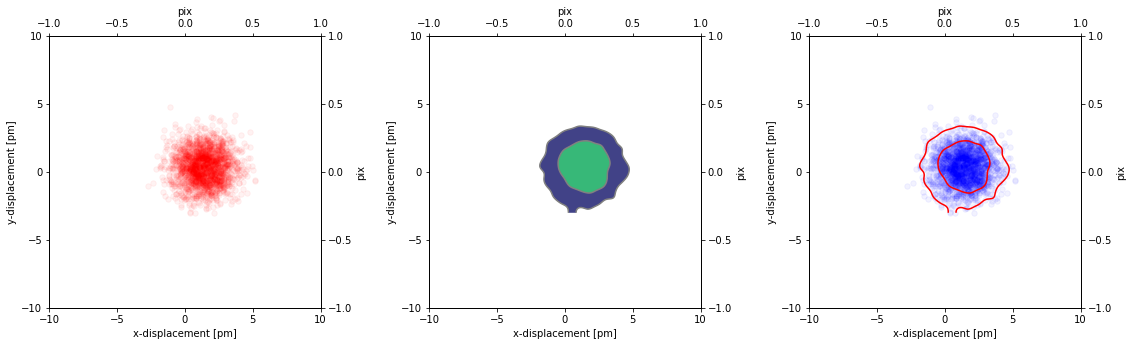

Mean of displacement [pm] = (-0.26, 0.58)
Standard deviation(x, y) of displacement [pm] = (1.87, 1.15)
Standard deviation(kobayashi) of displacement [pm] = (1.05)


In [19]:
k = 0  # number of Ti displacement for plot

# pred_flat_distanceをcalibration倍したリストを作成
multi_pred_flat_distance_x = [x[k] * calibration for x in pred_flat_distance_x]
multi_pred_flat_distance_y = [y[k] * calibration for y in pred_flat_distance_y]

# Create a GridSpec layout
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1], height_ratios=[1], wspace=0.4)

# Make plots
fig = plt.figure(figsize=(18.48, 5))
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

for i in range(num_sample):
    ax1.scatter(np.array(pred_flat_distance_x[i][k]*calibration), np.array(pred_flat_distance_y[i][k])*calibration, s=30, c="red", marker="o", alpha=0.05)
ax1.set_xlabel("x-displacement [pm]")
ax1.set_ylabel("y-displacement [pm]")
#ax1.set_xlim(-sorted(distances)[-1], sorted(distances)[-1])
#ax1.set_ylim(-sorted(distances)[-1], sorted(distances)[-1])
ax1.set_xlim(-10, 10)
ax1.set_ylim(-10, 10)
ax1_twinx = ax1.twinx()  # Create a new y-axis
ax1_twiny = ax1.twiny()  # Create a new x-axis
ax1_twinx.set_ylabel("pix")  # Set the label for the new y-axis
ax1_twiny.set_xlabel("pix")  # Set the label for the new x-axis
ax1_twiny.set_xlim(-1, 1)
ax1_twinx.set_ylim(-1, 1)

az.plot_kde(multi_pred_flat_distance_x, values2=multi_pred_flat_distance_y, ax=ax2, hdi_probs=[ 0.6827, 0.9545 ] )
ax2.set_xlabel("x-displacement [pm]")
ax2.set_ylabel("y-displacement [pm]")
ax2.set_xlim(-10, 10)
ax2.set_ylim(-10, 10)
ax2_twinx = ax2.twinx()  # Create a new y-axis
ax2_twiny = ax2.twiny()  # Create a new x-axis
ax2_twinx.set_ylabel("pix")  # Set the label for the new y-axis
ax2_twiny.set_xlabel("pix")  # Set the label for the new x-axis
ax2_twiny.set_xlim(-1, 1)
ax2_twinx.set_ylim(-1, 1)

az.plot_kde(multi_pred_flat_distance_x, values2=multi_pred_flat_distance_y, ax=ax3, hdi_probs=[ 0.6827, 0.9545 ],
            contour_kwargs={ "colors": "red", "alpha": 1 }, contourf_kwargs={ "alpha": 0 } )
for i in range(num_sample):
    ax3.scatter(np.array(pred_flat_distance_x[i][k]*calibration), np.array(pred_flat_distance_y[i][k])*calibration, s=30, c="blue", marker="o", alpha=0.05)
ax3.set_xlabel("x-displacement [pm]")
ax3.set_ylabel("y-displacement [pm]")
ax3.set_xlim(-10, 10)
ax3.set_ylim(-10, 10)
ax3_twinx = ax3.twinx()  # Create a new y-axis
ax3_twiny = ax3.twiny()  # Create a new x-axis
ax3_twinx.set_ylabel("pix")  # Set the label for the new y-axis
ax3_twiny.set_xlabel("pix")  # Set the label for the new x-axis
ax3_twiny.set_xlim(-1, 1)
ax3_twinx.set_ylim(-1, 1)

# Set integer tick intervals for ax4 and ax5
for ax in [ax1, ax2, ax3]:
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(5))
ax1_twinx.yaxis.set_major_locator(MultipleLocator(0.5))
ax1_twiny.xaxis.set_major_locator(MultipleLocator(0.5))
ax2_twinx.yaxis.set_major_locator(MultipleLocator(0.5))
ax2_twiny.xaxis.set_major_locator(MultipleLocator(0.5))
ax3_twinx.yaxis.set_major_locator(MultipleLocator(0.5))
ax3_twiny.xaxis.set_major_locator(MultipleLocator(0.5))

plt.savefig(data_dir + "\\" + "02_summary_bayese.png", dpi=1200)
plt.show()

#変位の平均と標準偏差の表示
pred_std_x = np.std(np.array(pred_flat_distance_x))*calibration
pred_std_y = np.std(np.array(pred_flat_distance_y))*calibration
pred_flat_distance = np.sqrt(np.array(pred_flat_distance_x)**2 + np.array(pred_flat_distance_y)**2)*calibration
pred_kobayashi_std = np.std(pred_flat_distance)

print("Mean of displacement [pm] = ({0:.2f}, {1:.2f})".format(np.mean(np.array(pred_flat_distance_x))*calibration, np.mean(np.array(pred_flat_distance_y))*calibration))
print("Standard deviation(x, y) of displacement [pm] = ({0:.2f}, {1:.2f})".format(pred_std_x, pred_std_y))
print("Standard deviation(kobayashi) of displacement [pm] = ({0:.2f})".format(pred_kobayashi_std))
#print("Standard deviation of displacement [pm] = ({0:.2f}, {1:.2f})".format(np.std(np.array(distances))*calibration))

## 9. Save/Load results of Bayesian inference

In [25]:
# save results of Bayesian inference
if os.name == "nt":      # If OS is Windows
    out_dir = os.path.dirname(cur_dir) + "\\data\\" + output_dir 
    os.mkdir(out_dir)
    out_dir += "\\"
if os.name == "posix":   # If OS is Linux or Mac
    data_dir = os.path.dirname(cur_dir) + "//data//" + output_dir
    os.mkdir(out_dir)
    out_dir += "//"

# save files
with open(out_dir + 'summary_all.pkl', 'wb') as f:
    pickle.dump(summary_all, f)
np.save(out_dir + "STEM_image.npy", img)
np.save(out_dir + "Bayes_peaks-x.npy", peaks_x)
np.save(out_dir + "Bayes_peaks-y.npy", peaks_y)

In [ ]:
# 「Peak fit using simple 2D Gaussian」まで実行 ⇒ このセルを実行 ⇒ 

# load results of Bayesian inference
fit_method = "bayes"
if os.name == "nt":      # If os is Windows
    out_dir = os.path.dirname(cur_dir) + "\\data\\" + output_dir + "\\"
if os.name == "posix":   # If os is Linux or Mac
    data_dir = os.path.dirname(cur_dir) + "//data//" + output_dir + "//"

# load files
with open(out_dir + 'summary_all.pkl', 'rb') as f:
    summary_all = pickle.load(f)
img = np.load(out_dir + 'STEM_image.npy')
peaks_x = np.load(out_dir + 'Bayes_peaks-x.npy')
peaks_y = np.load(out_dir + 'Bayes_peaks-y.npy')
sd_x_bayes = np.load(out_dir + 'Bayes_sd-x.npy')
sd_y_bayes = np.load(out_dir + 'Bayes_sd-y.npy')

summary_all

## 10. Test for example atom

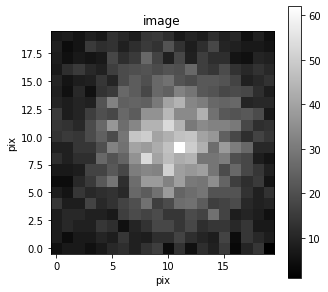

In [288]:
# Extract one atom
i = 1

# Make plots
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)
im = ax1.imshow(img[int(round(peaks_y[i]-size_peak/2)):int(round(peaks_y[i]+size_peak/2)), int(round(peaks_x[i]-size_peak/2)):int(round(peaks_x[i]+size_peak/2))], origin="lower", cmap="gray")
ax1.set_title("image")
ax1.set_xlabel("pix")
ax1.set_ylabel("pix")
#ax1.set_xlim(0, size_peak)
#ax1.set_ylim(0, size_peak)
plt.colorbar(im)
plt.savefig(data_dir + "\\" + "03_1atom.png", dpi=1200)
plt.show()

In [289]:
# Bayesian inference of atomic position

# Make x-y grating
x_linspace = np.linspace(0, size_peak-1, size_peak)
y_linspace = np.linspace(0, size_peak-1, size_peak)
x_grid, y_grid = np.meshgrid(x_linspace, y_linspace)
x_coords = x_grid.ravel()
y_coords = y_grid.ravel()
xy_coords = np.stack((x_coords, y_coords), axis=0).T    #pymcの構造に合わせて転置
peaks_x_bayes = np.zeros_like(peaks_x)

print("Bayesian Inference of atomic position: " + str(i+1) + "/" + str(len(peaks)))
#patch = img[int(round(peaks_y[i]-size_peak/2)):int(round(peaks_y[i]+size_peak/2)), int(round(peaks_x[i]-size_peak/2)):int(round(peaks_x[i]+size_peak/2))]
patch = img[int(round(peaks_y[i]-size_peak/2)):int(round(peaks_y[i]+size_peak/2)), int(round(peaks_x[i]-size_peak/2)):int(round(peaks_x[i]+size_peak/2))]
with pm.Model() as model:
    xy = pm.Data('Coordinate', xy_coords)
    mu = pm.Uniform('Atom Position (μ)', lower=0, upper=size_peak, shape=2)
    sigma = pm.Uniform('Noise (σ)', lower=0, upper=np.max(patch.ravel()))
    bckgrd = pm.Uniform('Background Intensity', lower=0, upper=np.mean(patch.ravel()))
    peak = pm.Uniform('Peak Intensity', lower=0, upper=np.max(patch.ravel())*2)
    sd_dist = pm.Exponential.dist(1)
    packed_chol = pm.LKJCholeskyCov("Cholesky Matrix", n=2, eta=1, sd_dist=sd_dist, compute_corr=False)
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = pm.Deterministic('Covariance Matrix', chol.dot(chol.T))
    inv =  pm.math.matrix_inverse(cov)
    y = pm.Normal('Intensity', mu=(np.exp( -pm.math.extract_diag(pm.math.matrix_dot((xy-mu), inv, (xy-mu).T))/2.0)) * peak + bckgrd, sigma=sigma, observed=patch.ravel())

#MCMC Sampling
with model:
    trace = pm.sample(
        draws=1100,
        tune=1000,
        chains=3,
        return_inferencedata=True
    )

Bayesian Inference of atomic position: 2/4705


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 1_000 tune and 1_100 draw iterations (3_000 + 3_300 draws total) took 116 seconds.
INFO:pymc3:Sampling 3 chains for 1_000 tune and 1_100 draw iterations (3_000 + 3_300 draws total) took 116 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Atom Position (μ)[0],10.348,0.083,10.186,10.492,0.001,0.001,4325.0,2417.0,1.0
Atom Position (μ)[1],9.540,0.082,9.390,9.691,0.001,0.001,3491.0,2433.0,1.0
...,...,...,...,...,...,...,...,...,...
"Covariance Matrix[1, 0]",-0.572,0.517,-1.558,0.380,0.009,0.008,3647.0,2338.0,1.0
"Covariance Matrix[1, 1]",17.734,1.085,15.707,19.738,0.026,0.018,1796.0,2395.0,1.0


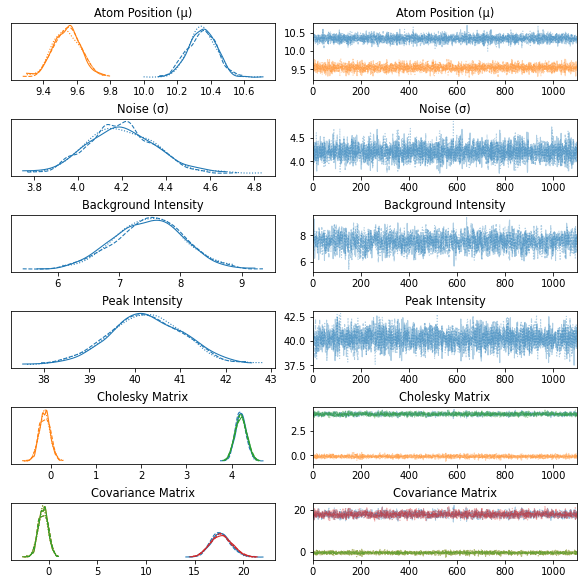

In [290]:
#Display summary
az.plot_trace(trace, backend_kwargs={"constrained_layout":True}, figsize=(8,8))
plt.savefig(data_dir + "\\" + "04_trace_plot.png", dpi=1200)
az.summary(trace)

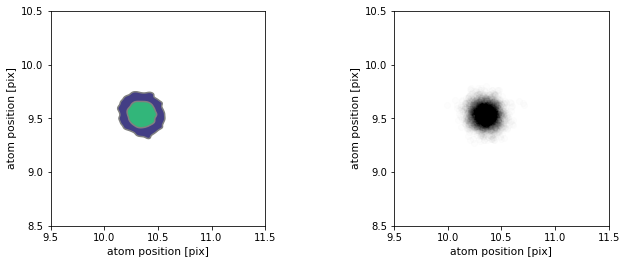

In [310]:
x_min, x_max, x_interval = 9.5, 11.5, 0.5
y_min, y_max, y_interval = 8.5, 10.5, 0.5

scatter_kwargs = { "c":"black", "marker":"o", "alpha":0.006 }
kde_kwargs = { "contour":True, "hdi_probs": [ 0.6827, 0.9545 ] }

# Create a GridSpec layout
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.6)

# Make plots
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

az.plot_pair(trace, var_names=["Atom Position (μ)"], kind="kde", marginals=False, ax=ax1, textsize=10, kde_kwargs=kde_kwargs);
ax1.set_xticks(np.arange(x_min, x_max + x_interval, x_interval))
ax1.set_yticks(np.arange(y_min, y_max + y_interval, y_interval))
ax1.set_xlabel("atom position [pix]")
ax1.set_ylabel("atom position [pix]")
ax1.set_aspect('equal', adjustable='box')

az.plot_pair(trace, var_names=["Atom Position (μ)"], kind="scatter", marginals=False, ax=ax2, textsize=10, scatter_kwargs=scatter_kwargs);
ax2.set_xticks(np.arange(x_min, x_max + x_interval, x_interval))
ax2.set_yticks(np.arange(y_min, y_max + y_interval, y_interval))
ax2.set_xlabel("atom position [pix]")
ax2.set_ylabel("atom position [pix]")
ax2.set_aspect('equal', adjustable='box')

plt.savefig(data_dir + "\\" + "05_scatter_posterior_dist.png", dpi=1200)

In [ ]:
#Display credible interval
az.plot_posterior(trace, hdi_prob=0.9, backend_kwargs={"constrained_layout":True}, figsize=(10,10), textsize=10);